# DJI - HSI Trnasfer Entropy (TE)



# This is an implementation of of section 4.3 

##  - The load data and preprocessing parts are obtained from:
### Universal Estimation of Directed Information (Jiao et al., 2013)

------
## Imports <a class="anchor" id="imports"></a>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.patches import Patch
import pandas as pd
from scipy.io import savemat, loadmat
%matplotlib inline
import matplotlib.dates as mdates

font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)


from keras.models import Model
from keras.layers import Dense, Input, LSTM, Activation, Softmax
from keras.initializers import glorot_normal
from keras import optimizers
from keras.callbacks import EarlyStopping 
import tensorflow as tf

Using TensorFlow backend.


------
## Load Data (Jiao et al., 2013) <a class="anchor" id="load-data"></a>

First we'll load the data. Because there are different holidays in China and the US, we first align all the data by date and then interpolate missing dates. Note that this does not interpolate over weekends (or other dates where both stock markets are closed), but just select dates where only one is open.

In [2]:
# load the data
dji = pd.read_csv('../DataFiles/universal/DJI.csv')
hsi = pd.read_csv('../DataFiles/universal/HSI.csv')
# convert adjusted closing price to numeric values
dji['Adj Close'] = pd.to_numeric(dji['Adj Close'], errors='coerce')
hsi['Adj Close'] = pd.to_numeric(hsi['Adj Close'], errors='coerce')
# convert date field to date type
dji['Date'] = pd.to_datetime(dji['Date'])
hsi['Date'] = pd.to_datetime(hsi['Date'])
# set the date as the dataframe's indexing field
dji.set_index(['Date'],inplace=True)
hsi.set_index(['Date'],inplace=True)
# align dates
(dji,hsi) = dji.align(hsi)
# interpolate missing dates (respective holidays)
dji = dji.interpolate()
hsi = hsi.interpolate()

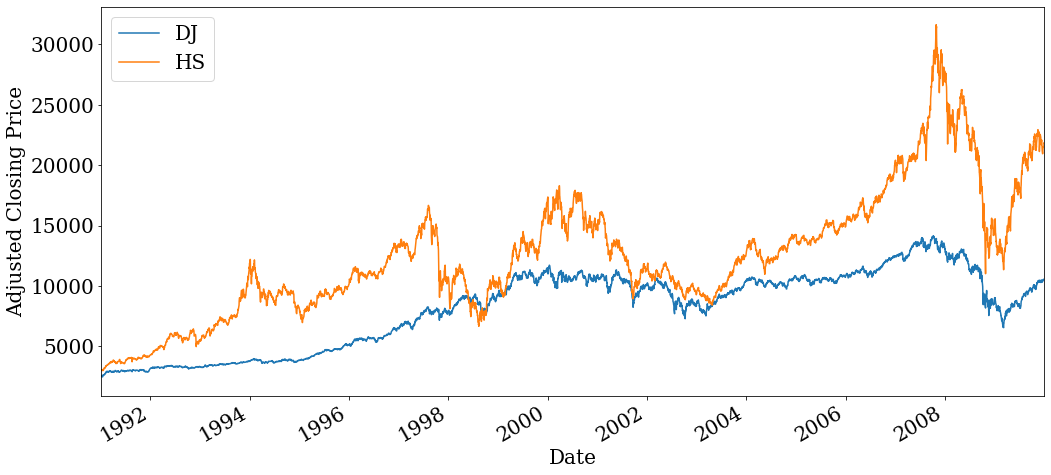

In [3]:
dji['Adj Close'].rolling(30, min_periods=1)
font = {'family' : 'serif',
        'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(figsize=(15,7))
dji['Adj Close'].plot(label='DJ',)
hsi['Adj Close'].plot(label='HS')
plt.ylabel('Adjusted Closing Price')
plt.legend()
xlim = plt.xlim()
plt.xlim([xlim[0]+365,xlim[1]-365])
plt.tight_layout()


------
## Preprocessing  (Jiao et al., 2013) <a class="anchor" id="preprocess"></a>

In order to utilize context tree weighting (CTW) prediction, we first apply two preprocessing steps from [this paper on the universal estimators of directed information](https://arxiv.org/abs/1201.2334). Namely, we look at the quantized daily percent difference in adjusted closing price, which is set to 0 if the stock goes down by more than 0.8%, 2 if it goes up by more the 0.8%, and 1 if it does not change by more than 0.8%.

In [4]:
# for each adjusted closing cost, find the percentage change from the previous day
ddji = [0]
for i in range(1,len(dji['Adj Close'])):
    ddji.append((dji['Adj Close'][i]-dji['Adj Close'][i-1])/dji['Adj Close'][i-1])
dji['Adj Close Diff'] = ddji

dhsi = [0]
for i in range(1,len(hsi['Adj Close'])):
    dhsi.append((hsi['Adj Close'][i]-hsi['Adj Close'][i-1])/hsi['Adj Close'][i-1])
hsi['Adj Close Diff'] = dhsi

In [5]:
df_prices_orig = pd.concat([dji['Adj Close'], hsi['Adj Close']], axis=1)
df_prices_orig.to_pickle('dji_hsi_orig.pkl')

In [6]:
df_prices_diff = pd.concat([dji['Adj Close Diff'], hsi['Adj Close Diff']], axis=1)
df_prices_diff.to_pickle('dji_hsi.pkl')

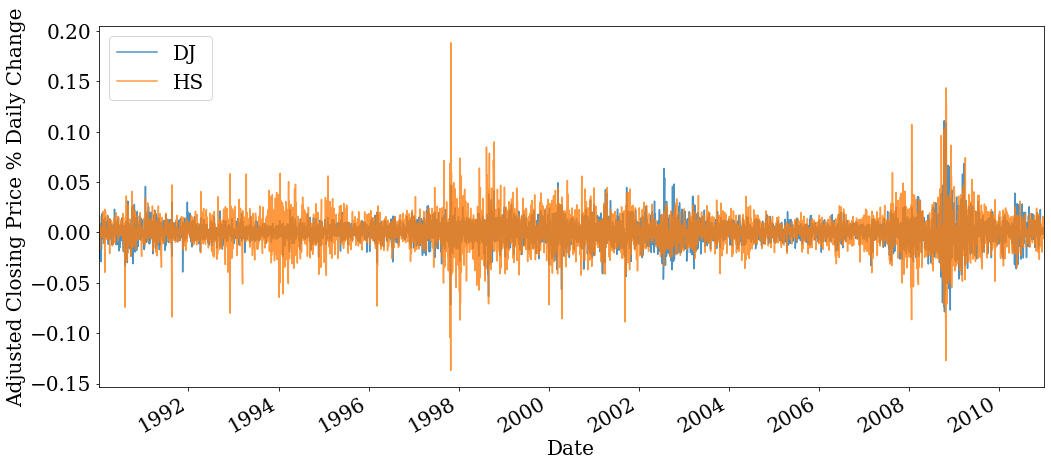

In [7]:
plt.figure(figsize=(15,7))
dji['Adj Close Diff'].plot(label='DJ',alpha=0.8)
hsi['Adj Close Diff'].plot(label='HS',alpha=0.8)
plt.ylabel('Adjusted Closing Price % Daily Change')
plt.legend()
plt.tight_layout()

In [8]:
# quantize each to be 0, 1, or 2 based on a 0.8% threshold
thresh = 0.8/100
ddji = [0]
for i in range(1,len(dji['Adj Close Diff'])):
    diff = dji['Adj Close Diff'][i]
    if diff < -thresh: ddji.append(0)
    elif diff > thresh: ddji.append(2)
    else: ddji.append(1)
dji['Adj Close Diff Quant'] = ddji

dhsi = [0]
for i in range(1,len(hsi['Adj Close Diff'])):
    diff = hsi['Adj Close Diff'][i]
    if diff < -thresh: dhsi.append(0)
    elif diff > thresh: dhsi.append(2)
    else: dhsi.append(1)
hsi['Adj Close Diff Quant'] = dhsi

In [9]:
data = pd.concat([dji['Adj Close Diff Quant'], hsi['Adj Close Diff Quant']], axis=1)

# Utils

In [10]:
# arranging the input data for RNN
def make_rnn_data(time_series, sequence_length):
    seq_lst = []
    time_series = np.array(time_series)
    for i in range((len(time_series)-sequence_length+1)):
        seq_lst.append(time_series[i:(i+sequence_length), :])
    return np.array(seq_lst)

In [11]:
# converting y to one hot encoding
def convert_to_one_hot(y, dict_size):
        dict_size = dict_size
        y_hot = np.eye(dict_size)[y.astype('int32')]
        return y_hot

In [12]:
# taking the last realization of every sequence vector as the target variable
def make_class(data, columns_num):
    y_train = data[:,-1, columns_num]
    return y_train


In [13]:
# caclulating the kl between the softmax distribution of stage 3 and 4 in the C-MINCE algorithm
def kl(d1,d2):
    kl = 0
    for i in range(len(d1)):
        kl += d1[i]*np.log((d1[i])/(d2[i]))
    return kl

def kl_calc_one_dim(pred1, pred2):
    kl_lst = []
    pred1 = np.clip(pred1, a_min = 1e-5, a_max = None)
    pred2 = np.clip(pred2, a_min = 1e-5, a_max = None)
    kl_lst.append(kl(pred1, pred2))
    return kl_lst

# preparing the data for the model

In [28]:
lag = 5
class_size = 3
dims = 2

In [29]:
z1 = make_rnn_data(data, lag)
z1.shape

(5457, 5, 2)

In [30]:
#for the direction dji to hsi
y_hsi = z1[1:, -1, 1]
#y_dji = z1[1:, -1, 0] #for the oposite direction
dji_hsi_past = z1[:-1, :, :]
hsi_past = np.reshape(z1[:-1, :, 1], (-1, lag, 1))
#dji_past = np.reshape(z1[:-1, :, 0], (-1, lag, 1))# for the oposite direction
y_hot = []
y_hot = convert_to_one_hot(y_hsi, class_size)

# defining the rnn model

In [31]:
def model_basic_classification(input_shape, class_size, dims):
    l0 = Input(shape=input_shape, dtype = 'float32', name = 'input_l')
    X = LSTM(units=50, return_sequences=False, kernel_initializer='glorot_normal', name = 'l2')(l0)
    X = Dense(units=50, kernel_initializer='glorot_normal', name = 'l5',  activation='relu')(X)    
    output = [Dense(class_size, activation='softmax', kernel_initializer='glorot_normal')(X) for i in range(dims) ]
    model = Model(input = [l0], outputs =  output )
    return model

In [32]:
def train_model(X, y, time_lags, feat_dims, epoch, stop_cond, class_size, output_size, batch_size=128):
    es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=stop_cond, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model = model_basic_classification([time_lags, feat_dims], class_size, output_size)
    print(model.summary())
    opt = optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(X, y, epochs = epoch, batch_size = batch_size, shuffle=True, \
                     validation_split=0.05, callbacks=[es])
    return model

# Training 

In [33]:
# step 3 - estimating the entropy only by using the past of HSI to predict its future
model = train_model(X=hsi_past, y=y_hot, time_lags=lag, feat_dims=1, epoch=500, stop_cond=50, class_size=3, output_size=1)

c:\users\shale\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  app.launch_new_instance()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (InputLayer)         (None, 5, 1)              0         
_________________________________________________________________
l2 (LSTM)                    (None, 50)                10400     
_________________________________________________________________
l5 (Dense)                   (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 13,103
Trainable params: 13,103
Non-trainable params: 0
_________________________________________________________________
None
Train on 5183 samples, validate on 273 samples
Epoch 1/500
5183/5183 [==============================] - 0s 89us/step - loss: 1.0417 - accuracy: 0.4989 - val_loss: 0.9851 - val_accuracy: 0.5531
Epoch 2/500
5183/5183 [==============================] 

In [34]:
# step 4 - estimating the entropy by using the past of HSI and DJI to predict HSI future
model_x_y_past = train_model(X=dji_hsi_past, y=y_hot, time_lags=lag, feat_dims=2, epoch=500, stop_cond=50, class_size=3, output_size=1)

c:\users\shale\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  app.launch_new_instance()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (InputLayer)         (None, 5, 2)              0         
_________________________________________________________________
l2 (LSTM)                    (None, 50)                10600     
_________________________________________________________________
l5 (Dense)                   (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 13,303
Trainable params: 13,303
Non-trainable params: 0
_________________________________________________________________
None
Train on 5183 samples, validate on 273 samples
Epoch 1/500
5183/5183 [==============================] - 0s 85us/step - loss: 1.0297 - accuracy: 0.5099 - val_loss: 0.9897 - val_accuracy: 0.5531
Epoch 2/500
5183/5183 [==============================] 

In [35]:
# stage 5 of C-MINCE - calculating the cross entropies difference 

In [36]:
kl_list = []
counter = 0
for i, j in zip (model_x_y_past.predict(dji_hsi_past), model.predict(hsi_past)):
    counter +=1
    kl_list.append(kl_calc_one_dim(i, j))
    print(counter)
np_kl = np.array(kl_list) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297


4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754


In [37]:
TE_dji_hsi = pd.concat([pd.DataFrame(data.index[:-5]), pd.DataFrame(np_kl[:, 0])], axis=1)
TE_dji_hsi.Date = pd.to_datetime(TE_dji_hsi.Date)
TE_dji_hsi.set_index('Date', inplace=True)

In [38]:
# taking rolling widnow of 30 days moving avergate of the TE
roll_dji_hsi = TE_dji_hsi.rolling(30, min_periods=1).mean()

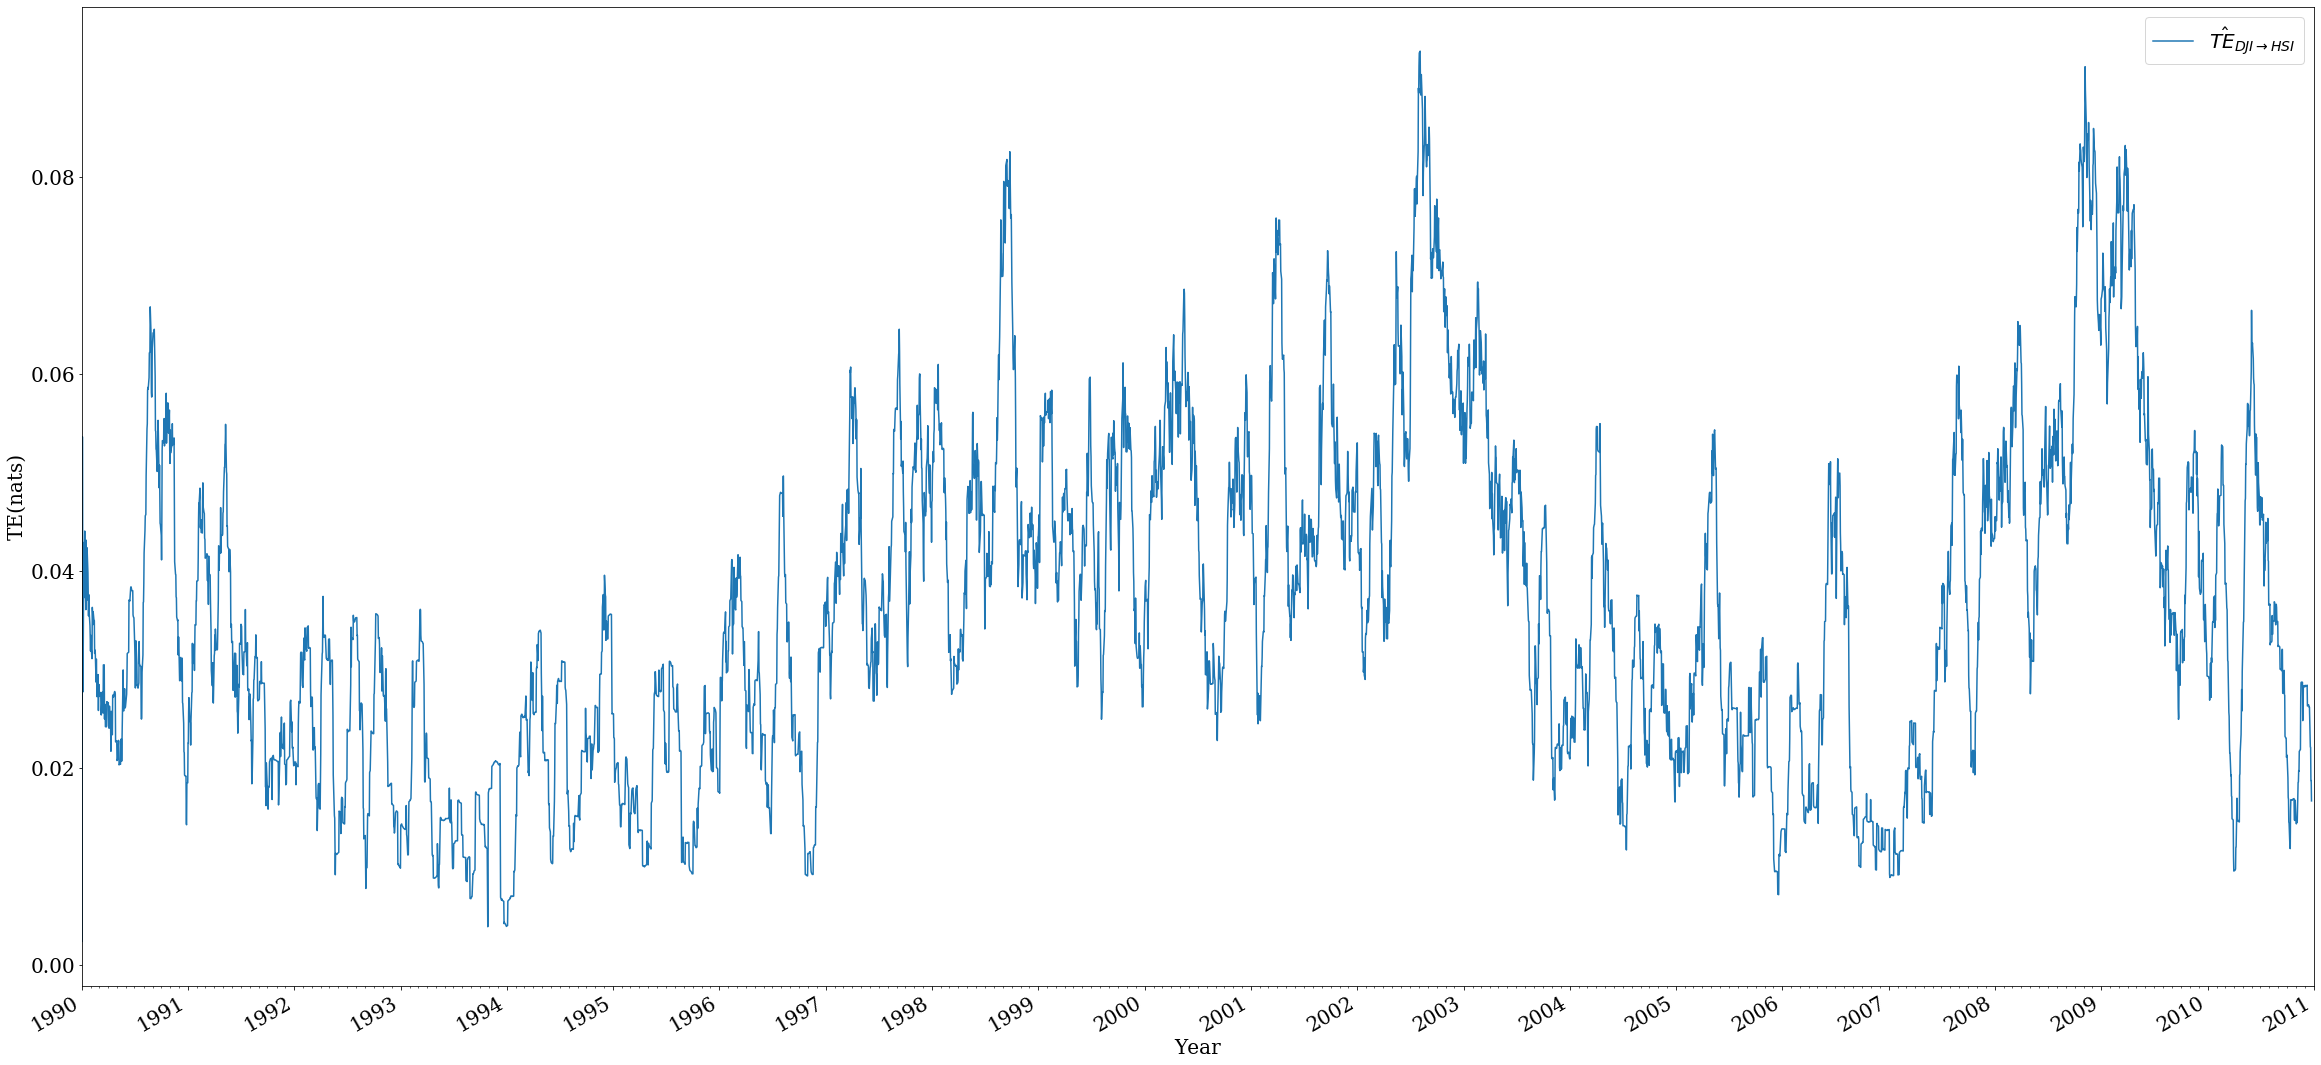

In [48]:
# plotting the TE. notice the periods of 1997-98, 2001-2003, 2008-2009 that are times of financial crises with larger TE
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(roll_dji_hsi, label=r'$\hat{TE}_{DJI\rightarrow HSI}$')
plt.legend()

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(roll_dji_hsi.index[0], 'Y')
datemax = np.datetime64(roll_dji_hsi.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
#ax.grid(True)
plt.xlabel('Year')
plt.ylabel('TE(nats)')
# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
plt.rcParams["figure.figsize"] = (40,20)
plt.show()